In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
import cv2
from pycrayon import CrayonClient
from torch.utils.data import DataLoader
from faster_rcnn.network import  clip_gradient
import torch

def collate_fn(batch):
    return batch

In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
from faster_rcnn.utils.data_generator import CocoGenerator
from faster_rcnn.utils.data_generator import Enqueuer

dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
#                         pre_proposal_folder=pre_proposal_folder,
                        transform=transforms.ToTensor())



data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


/data
/data/data/mscoco
loading annotations into memory...
Done (t=11.01s)
creating index...
index created!


In [4]:
from faster_rcnn.faster_rcnn import  RPN

In [ ]:
cc = CrayonClient(hostname="crayon", port=8889)
try:
    exp = cc.create_experiment("RPN")
except: 
    cc.remove_experiment("RPN")
    exp = cc.create_experiment("RPN")

disp_interval = 100
log_interval = 10

In [5]:
net = RPN()
net.cuda()
net.train()

RPN (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [12]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [13]:
optimizer = SGD(param, lr=1e-4, momentum=0.9, weight_decay=0.0005)

In [14]:
def train(data_gen, optimizer, model, epoch):
    model.train()
    train_loss = 0
    losses = []
    for step in range(1, epoch):
#         blobs = data_gen.next()
        blobs = cap[13499]
        if blobs is None:
            continue
        if step > epoch:
            break
        im_data = blobs['data']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        output = model(im_data, im_info, gt_boxes, gt_ishard, dontcare_areas)
        loss = model.loss
        print 'loss', loss
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(model, 10.)
        optimizer.step()
        loss_value = loss.data.cpu().float()
        losses.append(loss_value)
        
        if step % 1 == 0:

            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

#         if step % log_interval == 0:
#             exp.add_scalar_value('loss', loss.data[0], step=step)
#             exp.add_scalar_value('last_layers_loss', net.loss.data[0], step=step)

In [15]:
train(t, optimizer, net, 10)

[[ 2.3342514   6.42978573  5.60856581 -0.50729591]
 [ 3.42131448 -1.84061909 -1.15495563 -2.71984434]
 [ 3.62157059 -0.69235849  1.10734808 -0.09065878]
 ..., 
 [-1.24841475 -1.2153815  -3.73412895 -4.63251066]
 [ 2.38561606 -3.82597303 -4.31362295 -0.1562207 ]
 [-3.65702462  2.74694157  3.01427603 -0.82820523]]
anchors:
[[ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
rpn_cls_score.shape (1, 18, 37, 50)
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   5

step 5, image: COCO_train2014_000000309241.jpg, loss: 166.5974
[[ 2.35240555  6.35612917  5.56780624 -0.58441722]
 [ 3.32379651 -1.85272229 -1.15282595 -2.57008505]
 [ 3.57330823 -0.76148766  1.08455932 -0.08537855]
 ..., 
 [-1.1826545  -1.19722915 -3.58461499 -4.61005592]
 [ 2.26936793 -3.79773879 -4.4139533  -0.34420553]
 [-3.71565175  2.69588208  3.06190157 -0.93775475]]
anchors:
[[ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
anchor shapes:
[[ 183.   95.]
 [ 367.  191.]
 [ 735.  383.]
 [ 127.  127.]
 [ 255.  255.]
 [ 511.  511.]
 [  87.  175.]
 [ 175.  351.]
 [ 351.  703.]]
rpn_cls_score.shape (1, 18, 37, 50)
AnchorTargetLayer: height 37 width 50

im_size: (600.0, 800.0)
scale: 1.25
height, width: (37, 50)
rpn: gt_boxes.shape (3, 5)
rpn: gt_boxes [[ 140.    253.75  185.    430.     24.  ]


In [ ]:
torch.save(net.state_dict(), 'rpn.pkl')

In [ ]:
net.load_state_dict(torch.load('./rpn.pkl'))


In [16]:
blobs =  cap[13499]
im_data = blobs['data']
im_info = blobs['im_info']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
gt_ishard = blobs['gt_ishard']
dontcare_areas = blobs['dontcare_areas']

print blobs['boxes'] / im_info[0][2]
print blobs['image_info']
print im_data.shape
origin_gt_box =  blobs['boxes'] / im_info[0][2]
print origin_gt_box
print gt_boxes

[[ 112.  203.  148.  344.]
 [ 255.  198.  354.  311.]
 [ 318.  194.  457.  316.]]
{u'license': 1, u'file_name': u'COCO_train2014_000000309241.jpg', u'coco_url': u'http://mscoco.org/images/309241', u'height': 480, u'width': 640, u'date_captured': u'2013-11-16 12:01:50', u'flickr_url': u'http://farm2.staticflickr.com/1241/992106560_15b6dd2b92_z.jpg', u'id': 309241}
(1, 600, 800, 3)
[[ 112.  203.  148.  344.]
 [ 255.  198.  354.  311.]
 [ 318.  194.  457.  316.]]
[[ 140.    253.75  185.    430.     24.  ]
 [ 318.75  247.5   442.5   388.75   24.  ]
 [ 397.5   242.5   571.25  395.     24.  ]]


In [17]:
# net.load_state_dict(torch.load('./rpn.pkl'))

net.eval()
_, result = net(im_data, im_info, gt_boxes, gt_ishard, dontcare_areas)

[[ 2.26382446  6.25465441  5.55088186 -0.67979538]
 [ 3.1828289  -1.81742942 -1.16549301 -2.43885303]
 [ 3.53831339 -0.87832272  1.10337663 -0.04007328]
 ..., 
 [-1.15000963 -1.12204421 -3.35336351 -4.49514723]
 [ 2.01283765 -3.68948388 -4.46334219 -0.60569483]
 [-3.79983997  2.58096886  3.08999777 -1.02449846]]


In [18]:
box_data =  result.data.cpu().numpy()
features =  _.data.cpu().numpy()
print features.shape
print box_data.shape

(1, 512, 37, 50)
(300, 5)


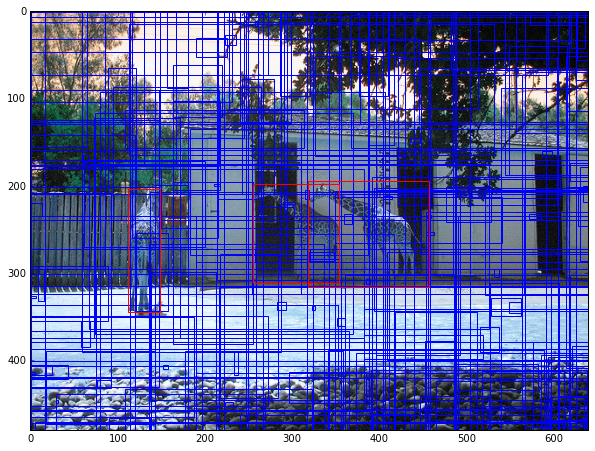

In [19]:
fig,ax = plt.subplots(1)
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, blobs['im_name'])
# Display the image
im_data = cv2.imread(img_path)

ax.imshow(im_data)
# Create a Rectangle patch
for i, box in enumerate(box_data):
    box = box[1:]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1] ,linewidth=1,edgecolor='b',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
for i, box in enumerate(origin_gt_box):
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

# debug max overlap